In [1]:
import os
import glob

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense

# Przygotowanie danych

In [4]:
dataset_path = "dataset"

In [5]:
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")

In [6]:
emotion_classes = os.listdir(train_path)
emotion_classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [7]:
train_emotion_count = {}
test_emotion_count = {}

for emotion_folder in emotion_classes:
    train_emotion_path = os.path.join(train_path, emotion_folder)
    test_emotion_path = os.path.join(test_path, emotion_folder)
    train_emotion_count[emotion_folder] = len(os.listdir(train_emotion_path))
    test_emotion_count[emotion_folder] = len(os.listdir(test_emotion_path))

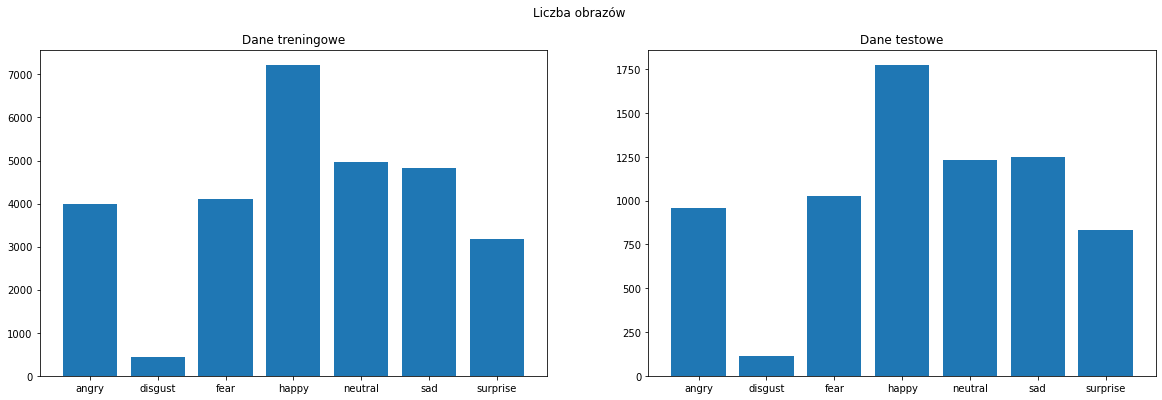

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].bar(train_emotion_count.keys(), train_emotion_count.values())
ax[0].set_title('Dane treningowe')
ax[1].bar(test_emotion_count.keys(), test_emotion_count.values())
ax[1].set_title('Dane testowe')

plt.suptitle('Liczba obrazów')
plt.show()

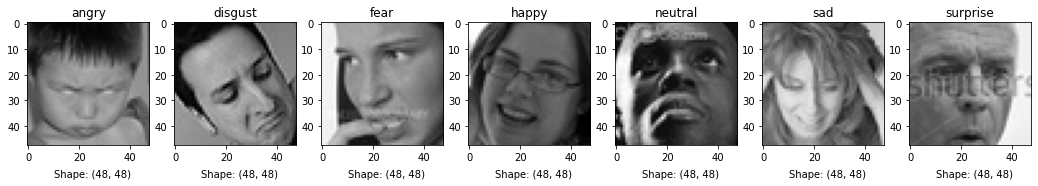

In [9]:
img_shape = 0
plt.figure(figsize=(18, 4))
for idx, emotion in enumerate(emotion_classes):
    emotion_path = os.path.join(train_path, emotion)
    img_path = glob.glob(f'{emotion_path}/*.jpg')[0]
    img = load_img(img_path)
    plt.subplot(1, len(emotion_classes), idx+1)
    plt.imshow(img)
    plt.title(emotion)
    img_shape = img.size
    plt.text(10, 60, f'Shape: {img_shape}')
plt.show()

In [10]:
train_data_gen = ImageDataGenerator(
    rescale = 1.0/255,
    validation_split = 0.1
)

test_data_gen = ImageDataGenerator(
    rescale = 1.0/255
)

In [11]:
print("Train data:")
train_data = train_data_gen.flow_from_directory(
    directory = train_path,
    target_size = (48, 48),
    batch_size = 64,
    subset='training',
    color_mode = 'grayscale',
    class_mode = 'categorical',
    shuffle=True
)

print("\nValidation data:")
validation_data = train_data_gen.flow_from_directory(
    directory = train_path,
    target_size = (48, 48),
    batch_size = 64,
    subset='validation',
    color_mode = 'grayscale',
    class_mode = 'categorical',
    shuffle=True
)

print("\nTest data:")
test_data = test_data_gen.flow_from_directory(
    directory = test_path,
    target_size = (48, 48),
    batch_size = 64,
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

Train data:
Found 25841 images belonging to 7 classes.

Validation data:
Found 2868 images belonging to 7 classes.

Test data:
Found 7178 images belonging to 7 classes.


# Stworzenie modelu

In [76]:
def get_model(input_shape, num_classes):    
    model = tf.keras.models.Sequential()
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape, data_format='channels_last'))
#     model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

#     model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
#     model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

#     model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
#     model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

#     model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
#     model.add(BatchNormalization())
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [65]:
input_shape = img_shape+(1,)

In [77]:
model = get_model(input_shape=input_shape, num_classes=len(emotion_classes))

In [67]:
# hyperparameters
lr = 0.01
decay = 1e-2

In [78]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [79]:
model.build(input_shape)

In [80]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_53 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_54 (Batc (None, 23, 23, 128)       512       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 11, 11, 128)      

# Nauka sieci

In [82]:
save_path = os.path.join('model', 'best_fer.hdf5')
model_checkpoint = ModelCheckpoint(save_path, save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=10, verbose=1)

callbacks = [early_stop, model_checkpoint] 

In [83]:
steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = validation_data.n // validation_data.batch_size
num_epochs = 500

history = model.fit(
    train_data,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_data,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/500
403/403 [==============================] - 8s 19ms/step - loss: 1.9895 - accuracy: 0.2085 - val_loss: 1.8464 - val_accuracy: 0.2518

Epoch 00001: val_loss improved from inf to 1.84636, saving model to model\best_fer.hdf5
Epoch 2/500
403/403 [==============================] - 8s 19ms/step - loss: 1.8263 - accuracy: 0.2430 - val_loss: 1.8154 - val_accuracy: 0.2507

Epoch 00002: val_loss improved from 1.84636 to 1.81544, saving model to model\best_fer.hdf5
Epoch 3/500
403/403 [==============================] - 8s 19ms/step - loss: 1.8008 - accuracy: 0.2505 - val_loss: 1.8665 - val_accuracy: 0.2496

Epoch 00003: val_loss did not improve from 1.81544
Epoch 4/500
403/403 [==============================] - 7s 18ms/step - loss: 1.7619 - accuracy: 0.2747 - val_loss: 1.7618 - val_accuracy: 0.2798

Epoch 00004: val_loss improved from 1.81544 to 1.76184, saving model to model\best_fer.hdf5
Epoch 5/500
403/403 [==============================] - 8s 20ms/step - loss: 1.6731 - accuracy: 0.


Epoch 00038: val_loss improved from 1.15585 to 1.14281, saving model to model\best_fer.hdf5
Epoch 39/500
403/403 [==============================] - 7s 18ms/step - loss: 1.1906 - accuracy: 0.5615 - val_loss: 1.1707 - val_accuracy: 0.5692

Epoch 00039: val_loss did not improve from 1.14281
Epoch 40/500
403/403 [==============================] - 7s 18ms/step - loss: 1.1693 - accuracy: 0.5693 - val_loss: 1.1787 - val_accuracy: 0.5593

Epoch 00040: val_loss did not improve from 1.14281
Epoch 41/500
403/403 [==============================] - 8s 19ms/step - loss: 1.1617 - accuracy: 0.5688 - val_loss: 1.1464 - val_accuracy: 0.5579

Epoch 00041: val_loss did not improve from 1.14281
Epoch 42/500
403/403 [==============================] - 7s 18ms/step - loss: 1.1669 - accuracy: 0.5683 - val_loss: 1.2397 - val_accuracy: 0.5518

Epoch 00042: val_loss did not improve from 1.14281
Epoch 43/500
403/403 [==============================] - 7s 18ms/step - loss: 1.1521 - accuracy: 0.5730 - val_loss: 1.12

# Testowanie, ewaluacja

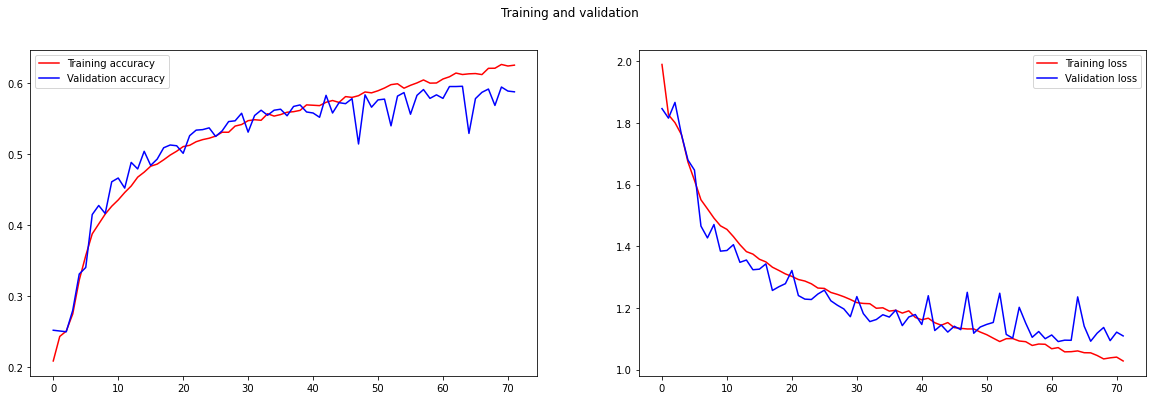

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'r', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'r', label='Training loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

In [85]:
# Wczytanie parametrów modelu
model.load_weights(save_path)

In [86]:
test_loss, test_acc = model.evaluate(test_data)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

113/113 [==============================] - 2s 16ms/step - loss: 1.0654 - accuracy: 0.6009
validation accuracy : 60.08637547492981%
validation loss : 1.0654252767562866


              precision    recall  f1-score   support

       angry       0.15      0.11      0.13       958
     disgust       0.10      0.03      0.04       111
        fear       0.14      0.06      0.08      1024
       happy       0.25      0.28      0.26      1774
     neutral       0.17      0.23      0.20      1233
         sad       0.17      0.20      0.18      1247
    surprise       0.11      0.11      0.11       831

    accuracy                           0.18      7178
   macro avg       0.16      0.15      0.14      7178
weighted avg       0.17      0.18      0.17      7178





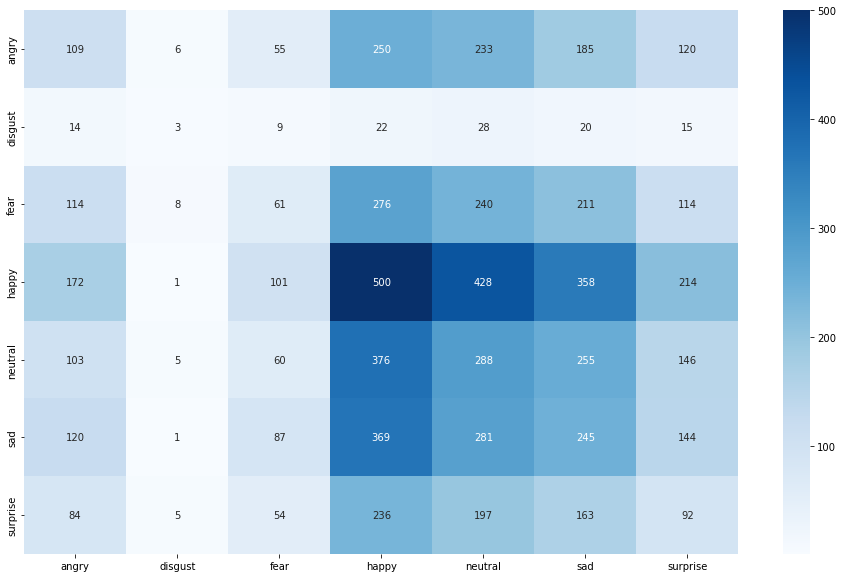

In [87]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = np.argmax(model.predict(test_data), axis=-1)
print(classification_report(test_data.classes, y_pred, target_names=test_data.class_indices.keys()), end='\n\n\n')

cm = confusion_matrix(test_data.classes, y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='.0f', xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.show()